# Ensembling: Blending and Stacking

In this notebook, we implement stacking of machine learning models. Stacking several uncorrelated models is known to generalize better than individual models. Stacking mainly requires good cross-validation strategy between levels of prediction. In particular, we will demostrate that maintaining the same cross-validation folds between levels minimizes overfitting.

In [1]:
import pandas as pd
import numpy as np
import time
import joblib
import random
from joblib import Parallel, delayed
from scipy.optimize import minimize
from xgboost import XGBClassifier

from sklearn import model_selection, linear_model, metrics, decomposition, ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone

from tqdm.notebook import tqdm as tqdm
from functools import partial, reduce
from typing import List
import warnings
warnings.simplefilter(action='ignore')

random.seed(42)
np.random.seed(42)
NUM_FOLDS = 5

## Dataset

The dataset consists of 50,000 IMDB movie reviews, specially selected for sentiment analysis. The sentiment of reviews is binary, with rating < 5 results in a sentiment score of 0, and rating >=7 resulting in a sentiment score of 1. No individual movie has more than 30 reviews. [^dataref]

[^dataref]: Would be good to perform group $k$-fold so that two reviews of the same movie don't get separated in the train and test sets. But wasn't able to find a good way to determine the movie each review is based on.

In [2]:
df = pd.read_csv('../input/kumarmanoj-bag-of-words-meets-bags-of-popcorn/labeledTrainData.tsv', sep='\t')
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


### Train and test split

In [3]:
df_train, df_test = model_selection.train_test_split(df, test_size=0.20)
print(df_train.shape, df_test.shape)

(20000, 3) (5000, 3)


### Cross-validation folds

Here we create cross-validation folds. This is important for evaluating models (i.e. estimating test performance) and creating meta-features that don't overfit to the train set.

In [4]:
df_train.loc[:, 'kfold'] = -1 
df_train = df_train.sample(frac=1.0).reset_index(drop=True)
y = df_train['sentiment'].values

skf = model_selection.StratifiedKFold(n_splits=NUM_FOLDS, random_state=42)
for f, (t_, v_) in enumerate(skf.split(X=df_train, y=y)):
    df_train.loc[v_, "kfold"] = f

In [5]:
df_train.kfold.value_counts()

0    4000
1    4000
2    4000
3    4000
4    4000
Name: kfold, dtype: int64

## Stacking and Blending

We define a class that automates training and prediction of stacked models. Several models can be trained on the training set whose predict probabilities can be used as feature for a further metamodel called a **stacker**. Observe that this process can be iterated to several more levels. To avoid creating meta features that are overfitted to the train set, the meta features are generated by out-of-fold (OOF) training and prediction of the models on the features of the previous level. This requires defining cross-validation folds. The same cross-validation folds will be used to generate metafeatures at deeper levels. This will be justified later. 

After generating metafeatures, the models will be retrained on the whole training set (not just on train folds). This increases accuracy of prediction on the test set. Finally, prediction on the test set will simulate conditions when the model was trained &mdash; essentially the test set acts like an extra validation fold.


:::{note}
Alternatively, we could make predictions on the test dataset using each base model immediately after it gets fitted on each fold. In our case, this would generate test-set predictions for five of each base models. Then, we would average the predictions per model to generate our level 1 meta features.

One benefit to this is that it’s less time consuming than the first approach (since we don’t have to retrain each model on the full training dataset). It also helps that our train meta features and test meta features should follow a similar distribution. However, the test meta features are likely more accurate in the first approach since each base model was trained on the full training dataset (as opposed to 80% of the training dataset, five times in the 2nd approach).
:::



### Implementation

Note that we **clone** models in the `model_dict_list` inside the `StackingCLassifier` object to avoid leaking state changes outside the instance of this class.

In [6]:
class StackingClassifier:
    """Implements model stacking for classification."""
    
    def __init__(self, model_dict_list, verbose=True):
        """Initialize by passing a list of dictionaries of name-model pairs 
        for each level."""
        
        self.model_dict_list = [
            {name: clone(model_dict[name]) for name in model_dict} 
            for model_dict in model_dict_list
        ]
        self.cv_scores_ = {}
        self.metafeatures_ = None
        self.verbose = verbose
        
    def fit(self, df):
        """Fit classifier. This assumes `df` is a DataFrame with "id", "kfold", 
        "sentiment" (target) columns, followed by features columns."""
                
        # Iterating over all stacking levels
        df = df.copy()
        metafeatures = []
        for m in range(len(self.model_dict_list)):
            
            # Get models in current layer
            model_dict = self.model_dict_list[m]
            level = m + 1
            
            # Identify feature columns, i.e. preds of prev. layer
            if m == 0:
                feature_cols = ['review']
            else:
                prev_level_names = self.model_dict_list[m-1].keys()
                feature_cols = [f'{name}_{level-1}' for name in prev_level_names]
            
            # Iterate over models in the current layer
            for model_name in model_dict.keys():
                if self.verbose:
                    print(f'\nLevel {level} preds: {model_name}')
                self.cv_scores_[f'{model_name}_{level}'] = []
                model = model_dict[model_name]
                
                # Generate feature for next layer models from OOF preds
                oof_preds = []
                for j in range(df.kfold.nunique()):
                    oof_pred, oof_auc = self._oof_pred(df, feature_cols, model, 
                                                        model_name, fold=j, level=level)
                    oof_preds.append(oof_pred)
                    self.cv_scores_[f'{model_name}_{level}'].append(oof_auc)
                
                pred = pd.concat(oof_preds)
                df = df.merge(pred[['id', f'{model_name}_{level}']], on='id', how='left')   
                metafeatures.append(f'{model_name}_{level}')
        
                # Train models on entire feature columns for inference
                model.fit(df[feature_cols], df.sentiment.values)
        
        self.metafeatures_ = df[metafeatures]
        return self
        
    def predict_proba(self, test_df):
        """Return classification probabilities."""
        
        test_df = test_df.copy()
        
        # Iterate over layers to make predictions
        for m in range(len(self.model_dict_list)):
            
            # Get models for current layer
            model_dict = self.model_dict_list[m]
            level = m + 1
            
            # Get feature columns to use for prediction
            if m == 0:
                feature_cols = ['review']
            else:
                prev_names = self.model_dict_list[m-1].keys()
                feature_cols = [f"{model_name}_{level-1}" for model_name in prev_names]

            # Append predictions to test DataFrame
            for model_name in model_dict.keys():
                model = model_dict[model_name]
                pred = model.predict_proba(test_df[feature_cols])[:, 1] 
                test_df.loc[:, f"{model_name}_{level}"] = pred
                    
        # Return last predictions
        return np.c_[1 - pred, pred]
        
    def _oof_pred(self, df, feature_cols, model, model_name, fold, level):
        "Train on K-1 folds, predict on fold K. Return OOF predictions with IDs."

        # Get folds; include ID and target cols, and feature cols
        df_trn = df[df.kfold != fold][['id', 'sentiment']+feature_cols]
        df_oof = df[df.kfold == fold][['id', 'sentiment']+feature_cols]
        
        # Fit model.
        model.fit(df_trn[feature_cols], df_trn.sentiment.values)
        oof_pred = model.predict_proba(df_oof[feature_cols])[:, 1] 
        auc = metrics.roc_auc_score(df_oof.sentiment.values, oof_pred)
        if self.verbose:
            print(f"fold={fold}, auc={auc}")

        # Return OOF predictions with ids
        df_oof.loc[:, f"{model_name}_{level}"] = oof_pred
        return df_oof[["id", f"{model_name}_{level}"]], auc

### Blending

Let's start with a simple stacked model where we simply perform a weighted average of the prediction probabilities. This method is called **blending**. We will use three base models to generate probabilities. Hopefully these are uncorrelated:
1. Logistic Regression + TF-IDF
2. Logistic Regression + Count Vectorizer
3. Random Forest + TF-IDF + SVD

In [7]:
class ReviewColumnExtractor(BaseEstimator, ClassifierMixin):
    """Extract text column, e.g. letting X = df_train[['review']]
    as train dataset for TfidfVectorizer and CountVectorizer does
    not work as expected."""
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.review

Initialize base models:

In [8]:
lr = make_pipeline(
    ReviewColumnExtractor(),
    TfidfVectorizer(max_features=1000),
    linear_model.LogisticRegression()
)

lr_cnt = make_pipeline(
    ReviewColumnExtractor(),
    CountVectorizer(),
    linear_model.LogisticRegression(solver='liblinear')
)

rf_svd = make_pipeline(
    ReviewColumnExtractor(),
    TfidfVectorizer(max_features=None),
    decomposition.TruncatedSVD(n_components=120),
    ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

Run training:

In [9]:
basemodels = {'lr': lr, 'lr_cnt': lr_cnt, 'rf_svd': rf_svd}
stack = StackingClassifier([basemodels])
stack.fit(df_train)


Level 1 preds: lr
fold=0, auc=0.9307090940954617
fold=1, auc=0.9337374849499398
fold=2, auc=0.9293829675318702
fold=3, auc=0.9317784771139086
fold=4, auc=0.9360097440389763

Level 1 preds: lr_cnt
fold=0, auc=0.9390758629206916
fold=1, auc=0.940747762991052
fold=2, auc=0.9454345317381269
fold=3, auc=0.9440257761031045
fold=4, auc=0.9460965343861376

Level 1 preds: rf_svd
fold=0, auc=0.8704328334738753
fold=1, auc=0.8767106318425274
fold=2, auc=0.8794640178560714
fold=3, auc=0.875936878747515
fold=4, auc=0.8851476655906624


Check if basemodels are uncorrelated:

In [10]:
stack.metafeatures_.corr()

,lr_1,lr_cnt_1,rf_svd_1
lr_1,1.000000,0.884478,0.834850
lr_cnt_1,0.884478,1.000000,0.727088
rf_svd_1,0.834850,0.727088,1.000000


The model saves learned probabilistic features:

In [11]:
stack.metafeatures_.head()

,lr_1,lr_cnt_1,rf_svd_1
0,0.900958,0.992376,0.64
1,0.935501,1.000000,0.49
2,0.140792,0.062266,0.33
3,0.836528,0.468958,0.72
4,0.620537,0.593996,0.62


We can also check scores of the base models on each validation fold. This informs us of the stability of the folds and the cross-validation performance of the base models. 

In [12]:
pd.DataFrame(stack.cv_scores_).describe().loc[['mean', 'std']]

,lr_1,lr_cnt_1,rf_svd_1
mean,0.932324,0.943076,0.877538
std,0.002605,0.003042,0.005370


Let's try to blend the probabilities using some hand-designed coefficients.

In [13]:
target = df_train.sentiment.values

# roc is scale invariant, so we dont bother dividing by total weights
avg_preds = (stack.metafeatures_ * [1, 1, 1]).sum(axis=1)
wtd_preds = (stack.metafeatures_ * [1, 3, 1]).sum(axis=1)
rank_avg_preds = (stack.metafeatures_.rank() * [1, 1, 1]).sum(axis=1)
rank_wtd_preds = (stack.metafeatures_.rank() * [1, 3, 1]).sum(axis=1)

# Calculate AUC over combined OOF preds
print(f"Train OOF-AUC (averaged):     ", metrics.roc_auc_score(target, avg_preds))
print(f"Train OOF-AUC (wtd. avg):     ", metrics.roc_auc_score(target, wtd_preds))
print(f"Train OOF-AUC (rank avg):     ", metrics.roc_auc_score(target, rank_avg_preds)) 
print(f"Train OOF-AUC (wtd. rank avg):", metrics.roc_auc_score(target, rank_wtd_preds))

Train OOF-AUC (averaged):      0.9461329255398613
Train OOF-AUC (wtd. avg):      0.9472926597265017
Train OOF-AUC (rank avg):      0.9414669386956488
Train OOF-AUC (wtd. rank avg): 0.9477579314061324


Since these coefficients are hand-designed, we may want to devise a strategy for automatically finding the optimal coefficients for blending. This is accomplished by the folowing class.

In [14]:
class Blender(BaseEstimator, ClassifierMixin):
    """Implement blending that maximizes AUC score."""
    
    def __init__(self, rank=False, random_state=42):
        self.coef_ = None
        self.rank = rank
        self.random_state = random_state

    def fit(self, X, y):
        """Find optimal blending coefficients."""
        
        if self.rank:
            X = X.rank()

        self.coef_ = self._optimize_auc(X, y)
        return self

    def predict_proba(self, X):
        """Return blended probabilities for class 0 and class 1."""
        
        if self.rank:
            X = X.rank()
            
        pred = np.sum(X * self.coef_, axis=1)
        return np.c_[1 - pred, pred]

    def _auc(self, coef, X, y):
        """Calculate AUC of blended predict probas."""

        auc = metrics.roc_auc_score(y, np.sum(X * coef, axis=1))
        return -1.0 * auc # min -auc = max auc
    
    def _optimize_auc(self, X, y):
        """Maximize AUC as a bound-constrained optimization problem using Nelder-Mead 
        method with Dirichlet init. 
        
        Reference: 
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
        """
        partial_loss = partial(self._auc, X=X, y=y) 
        rng = np.random.RandomState(self.random_state)
        init_coef = rng.dirichlet(np.ones(X.shape[1]))
        return minimize(partial_loss, init_coef, 
                        method='Nelder-Mead', 
                        bounds=[(0, 1)]*X.shape[1])['x']

This implementation uses `partial` from `functools` and `minimize` from `scipy.optimize` to minimize the coefficients constained in $(0, 1).$ The initial values of the coefficient are drawn from a Dirichlet distribution $\operatorname{Dir}(\boldsymbol{\alpha})$ with $\boldsymbol{\alpha} = [1, 1, 1].$

In [15]:
target = df_train.sentiment.values

# Blended predictions
blender = Blender()
blender.fit(stack.metafeatures_, target)
combined_oof_preds = (stack.metafeatures_ * blender.coef_).sum(axis=1)

# Blended ranked predictions
blender_rk = Blender(rank=True)
blender_rk.fit(stack.metafeatures_, target)
combined_oof_rk_preds = (stack.metafeatures_.rank() * blender_rk.coef_).sum(axis=1)

print(f"Train OOF-AUC (Blended):    ", metrics.roc_auc_score(target, combined_oof_preds))
print(f"Train OOF-AUC (Blended rk.):", metrics.roc_auc_score(target, combined_oof_rk_preds))

Train OOF-AUC (Blended):     0.9478070215833478
Train OOF-AUC (Blended rk.): 0.9486322045622584


Note that Train OOF-AUC is not the same as train AUC. However, this should be a better approximation of the test AUC. Calculating the AUC on the entire out-of-fold predictions involves tracking the rows of the confusion matrix, which is the sum of the confusion matrix of each fold, over all thresholds. On the other hand, the latter approach tracks each confusion matrix separately, then averages the individual AUCs. The two should be similar to cross-validation scores if error is well-distributed between folds &mdash; and we are blending probabilities. [^ref]

[^ref]: For some reason OOF-AUC is bad when blending ranking models, e.g. linear regression, with usual classifiers, even after transforming predict probabilities to rank.

In [16]:
# Inference
test_target = df_test.sentiment.values
test_features = []
for model_name in stack.model_dict_list[0].keys():
    test_features.append(stack.model_dict_list[0][model_name].predict_proba(df_test)[:, 1])

test_pred = (pd.DataFrame(np.c_[test_features].T) * blender.coef_).sum(axis=1)
test_rk_pred = (pd.DataFrame(np.c_[test_features].T) * blender_rk.coef_).sum(axis=1)
print('Test AUC (Blended):    ', metrics.roc_auc_score(test_target, test_pred))
print('Test AUC (Blended rk.):', metrics.roc_auc_score(test_target, test_rk_pred))

Test AUC (Blended):     0.9538357335519699
Test AUC (Blended rk.): 0.9538208526924514


:::{tip}
Using blended **rank probabilities** is a good trick when optimizing AUC score. Here individual probabilities are replaced by their rank index. Recall that AUC only cares about the predict probability of a randomly chosen negative examples to be assigned lower predict proba than a randomly chosen positive example. Note that this only works for ensembles; for single models using rank probabilities does not affect AUC score.
:::

### XGB Metamodel

Blending can be easily generalized to more complex machine learning model that learns and predicts with the metafeatures using more complex algorithms. For example, we can use `XGBoostClassifier`.

In [17]:
basemodels = {'lr': lr, 'lr_cnt': lr_cnt, 'rf_svd': rf_svd}
metamodel = {'xgb': XGBClassifier(eval_metric="logloss", use_label_encoder=False)}
stack = StackingClassifier([basemodels, metamodel])
stack.fit(df_train)


Level 1 preds: lr
fold=0, auc=0.9307090940954617
fold=1, auc=0.9337374849499398
fold=2, auc=0.9293829675318702
fold=3, auc=0.9317784771139086
fold=4, auc=0.9360097440389763

Level 1 preds: lr_cnt
fold=0, auc=0.9390758629206916
fold=1, auc=0.940747762991052
fold=2, auc=0.9454345317381269
fold=3, auc=0.9440257761031045
fold=4, auc=0.9460965343861376

Level 1 preds: rf_svd
fold=0, auc=0.874721843124147
fold=1, auc=0.8784090136360546
fold=2, auc=0.8775547602190409
fold=3, auc=0.8761697546790187
fold=4, auc=0.8833325333301333

Level 2 preds: xgb
fold=0, auc=0.9397077393424135
fold=1, auc=0.9419528928115714
fold=2, auc=0.9441767767071068
fold=3, auc=0.9454490317961272
fold=4, auc=0.9465114110456443


In [18]:
y_train = df_train.sentiment.values
y_test = df_test.sentiment.values

print(f"Train AUC (XGB stack):", metrics.roc_auc_score(y_train, stack.predict_proba(df_train)[:, 1]))
print(f"Test AUC  (XGB stack):", metrics.roc_auc_score(y_test, stack.predict_proba(df_test)[:, 1]))

Train AUC (XGB stack): 0.9997059489384758
Test AUC  (XGB stack): 0.9497394169487228


In [19]:
pd.DataFrame(stack.cv_scores_).describe().loc[['mean', 'std']]

,lr_1,lr_cnt_1,rf_svd_1,xgb_2
mean,0.932324,0.943076,0.878038,0.943560
std,0.002605,0.003042,0.003275,0.002742


Observe that cross-validated AUC scores is indicative of test performance. Meanwhile, train AUC is useless. A better estimate is the mean cross-validation AUC score. If we assume that each fold has the same error distribution, then this should approximate the test AUC which can be thought of as predicting on another fold. Indeed, the above results supports this.

### Conclusion

The above examples of building ensembles with **blending** or **stacking** (e.g. with XGBoost) show that stacked models significantly outperform single models.

## Parallelizing Model Training

Generating features require training one model for each fold. This is very slow. Note that each training process is independent of the other (they only use static features from the previous level), so in principle can be easily parallelized. For this task, we parallelize only the training on cross-validation folds. During inference, parallelizing results in worse times, likely due to overhead. 

We implement parallelizing training on CV folds using `joblib.Parallel`. Some remarks:

* Setting `backend='loky'` is important. Locally (Mojave 10.14.6), setting `backend='multiprocessing'` with an XGBoost classifier causes training to hang. In a Kaggle kernel, `multiprocessing` doesn't seem to work at all, even without using an XGBoost model. Using the `loky` backend seems to work consistently across platforms. 

+++

* Setting `nthread=1` for XGBClassifier decreases train trime from ~250s to ~100s with backend `loky` and `n_jobs=-1`. Note that the former time is way worse than sequential evaluation. 

+++

* Joblib pickles every object used inside `Parallel`. Best to use stateless objects. Careful about shared memory. Using `n_jobs=1` turns off parallel computing for debugging.

Results below show that there is significant speed up with parallelization using the `loky` backend. Consider this implementation the current stable version of our implementation of stacking.

In [20]:
class LinearRegressionClassifier(BaseEstimator, ClassifierMixin):
    """Linear regression for model-based AUC optimization.
    Note that we transform probabilities to rank probabilities!"""
    
    def __init__(self): 
        self.lr = linear_model.LinearRegression()
        
    def fit(self, X, y):
        self.lr.fit(pd.DataFrame(X).rank(), y)
        return self
        
    def predict_proba(self, X):
        return np.c_[[0]*len(X), self.lr.predict(pd.DataFrame(X).rank())]

This defines a linear regression ranking model.

In [21]:
class StackingClassifierParallel(BaseEstimator, ClassifierMixin):
    """Implements model stacking for classification."""
    
    def __init__(self, model_dict_list, n_jobs=1, backend='loky', verbose=1):
        """Initialize by passing `model_dict` which is a list of dictionaries 
        of name-model pairs for each level. Models should have inter-level
        unique names."""
        
        self.model_dict_list = [
            { name: clone(model_dict[name]) for name in model_dict } 
            for model_dict in model_dict_list
        ]
        self.cv_scores_ = {}
        self.metafeatures_ = None
        self.n_jobs = n_jobs
        self.backend = backend
        self.verbose = verbose
    
    def fit(self, df):
        """Fit classifier. Assumes `df` is a DataFrame with 'id', 'kfold', and 
        'sentiment' (target) columns, followed by features columns."""
        
        # Iterating over all stacking levels
        df = df.copy()
        metafeatures = []
        for m in tqdm(range(len(self.model_dict_list)), leave=False):
            
            # Get models in current layer
            model_dict = self.model_dict_list[m]
            level = m + 1
            
            # Identify feature columns, i.e. preds of prev. layer
            if m == 0:
                feature_cols = ['review']
            else:
                prev_level_names = self.model_dict_list[m-1].keys()
                feature_cols = [f'{name}_{level-1}' for name in prev_level_names]
            
            # Parallel context manager. Prevents discarding of workers for each model
            with Parallel(n_jobs=self.n_jobs, backend=self.backend, verbose=self.verbose) as parallel:
                
                # Iterate over models in the current layer
                for model_name in tqdm(model_dict.keys(), leave=False):
                    
                    # Generate feature for next layer models from OOF preds
                    # Cloning the model here releases the weights from prev. fit.
                    model = model_dict[model_name]
                    out = parallel(delayed(self._predict_fold)(
                            df, feature_cols, fold,
                            model_name, clone(model),
                            level
                        ) for fold in df.kfold.unique()
                    )

                    # Load all OOF predictions and AUCs
                    fold_preds, cv_scores = list(zip(*out))
                    
                    # Assign cv scores for model and append predictions to df
                    self.cv_scores_[f'{model_name}_{level}'] = cv_scores
                    pred_df = pd.concat(fold_preds)
                    df = df.merge(pred_df, how='left', on='id')
                    metafeatures.append(f'{model_name}_{level}')
                    
                    # Refit model on entire feature columns for inference
                    model.fit(df[feature_cols], df.sentiment)
                    
        # Save learned metafeatures
        self.metafeatures_ = df[metafeatures]
        return self
    
    def predict_proba(self, df):
        """Return classification probabilities."""
        
        # Iterate over layers to make predictions
        df = df.copy()
        for m in range(len(self.model_dict_list)):
            
            # Get models for current layer
            model_dict = self.model_dict_list[m]
            level = m + 1
            
            # Get feature columns to use for prediction
            if m == 0:
                feature_cols = ['review']
            else:
                prev_names = self.model_dict_list[m-1].keys()
                feature_cols = [f"{model_name}_{level-1}" for model_name in prev_names]

            # Append predictions to test DataFrame
            for model_name in model_dict.keys():
                model = model_dict[model_name]
                pred = model.predict_proba(df[feature_cols])[:, 1] 
                df.loc[:, f"{model_name}_{level}"] = pred
                    
        # Return last predictions
        return np.c_[1 - pred, pred]

    def _predict_fold(self, df, feature_cols, fold, model_name, model, level):
        "Make out-of-fold predictions. Return predict probas and AUC."
        
        X_train = df[df.kfold != fold][feature_cols]
        y_train = df[df.kfold != fold].sentiment.values
        
        X_valid = df[df.kfold == fold][feature_cols] 
        y_valid = df[df.kfold == fold].sentiment.values
        pred_id = df[df.kfold == fold].id

        # Fit model
        model.fit(X_train, y_train)
        
        # Return fold predictions along with fold AUC
        pred = model.predict_proba(X_valid)[:, 1] 
        auc = metrics.roc_auc_score(y_valid, pred)
        return pd.DataFrame({"id": pred_id, f"{model_name}_{level}": pred}), auc

Define the models for each level.

In [22]:
# Base models
level1 = {
    'lr': make_pipeline(
        ReviewColumnExtractor(),
        TfidfVectorizer(max_features=1000),
        linear_model.LogisticRegression(random_state=42)
    ), 
    
    'lr_cnt': make_pipeline(
        ReviewColumnExtractor(),
        CountVectorizer(), 
        linear_model.LogisticRegression(solver='liblinear', random_state=42)
    ), 
}

# Meta models
level2 = {
    'lr': linear_model.LogisticRegression(random_state=42),
    'linreg': make_pipeline(StandardScaler(), LinearRegressionClassifier()),
    'xgb': XGBClassifier(eval_metric="logloss", 
                         use_label_encoder=False, 
                         nthread=1, 
                         random_state=42)
}

# Meta models
level3 = {
    'linreg': make_pipeline(StandardScaler(), LinearRegressionClassifier()),
    'xgb': XGBClassifier(eval_metric="logloss", 
                         use_label_encoder=False, 
                         nthread=1,
                         random_state=42)
}

# Blender head: rank true for linear reg.
level4 = {'blender': Blender(rank=True, random_state=42)}

:::{caution}
Setting `nthread=1` for `XGBClassifier` decreases train time for the parallel stacker from ~250s to ~100s. This goes from worse to better than sequential. 

See also https://github.com/dmlc/xgboost/issues/2163 and other related issues.
:::

In [23]:
model_dict_list = [level1, level2, level3, level4]

Start timing runs:

In [24]:
times = []
for i in range(3):
    start_time = time.time()
    stack_parallel = StackingClassifierParallel(model_dict_list, n_jobs=-1)
    stack_parallel.fit(df_train)
    times.append(time.time() - start_time)
    
times = np.array(times)
times.mean(), times.std()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.7s finished


  0%|          | 0/3 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


  0%|          | 0/2 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished


  0%|          | 0/1 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.8s finished


  0%|          | 0/3 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


  0%|          | 0/2 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


  0%|          | 0/1 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.8s finished


  0%|          | 0/3 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


  0%|          | 0/2 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished


  0%|          | 0/1 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished


(115.9530455271403, 2.5860104752521766)

In [25]:
times = []
for i in range(3):
    start_time = time.time()
    stack = StackingClassifier(model_dict_list)
    stack.fit(df_train)
    times.append(time.time() - start_time)
    
times = np.array(times)
times.mean(), times.std()


Level 1 preds: lr
fold=0, auc=0.9307090940954617
fold=1, auc=0.9337374849499398
fold=2, auc=0.9293829675318702
fold=3, auc=0.9317784771139086
fold=4, auc=0.9360097440389763

Level 1 preds: lr_cnt
fold=0, auc=0.9390758629206916
fold=1, auc=0.940747762991052
fold=2, auc=0.9454345317381269
fold=3, auc=0.9440257761031045
fold=4, auc=0.9460965343861376

Level 2 preds: lr
fold=0, auc=0.9442413745430928
fold=1, auc=0.945928033712135
fold=2, auc=0.94625628502514
fold=3, auc=0.9478717914871659
fold=4, auc=0.9503710514842059

Level 2 preds: linreg
fold=0, auc=0.944894376012346
fold=1, auc=0.9475325401301605
fold=2, auc=0.9485367941471765
fold=3, auc=0.949123546494186
fold=4, auc=0.9509450537802152

Level 2 preds: xgb
fold=0, auc=0.9407056165876373
fold=1, auc=0.9425302701210806
fold=2, auc=0.9456667826671307
fold=3, auc=0.9453982815931263
fold=4, auc=0.9475127900511602

Level 3 preds: linreg
fold=0, auc=0.9450431263470344
fold=1, auc=0.9472022888091551
fold=2, auc=0.9484632938531754
fold=3, auc

(144.20534483591715, 2.0196589478472604)

Observe that parallel training has a ~20% speed up over sequential training!

Testing if predictions agree:

In [26]:
times = []
for i in range(3):
    start_time = time.time()
    parallel_pred = stack_parallel.predict_proba(df_test)[:, 1]
    times.append(time.time() - start_time)
    
times = np.array(times)
times.mean(), times.std()

(3.07025941212972, 0.06647048728835221)

In [27]:
times = []
for i in range(3):
    start_time = time.time()
    usual_pred = stack.predict_proba(df_test)[:, 1]
    times.append(time.time() - start_time)
    
times = np.array(times)
times.mean(), times.std()

(3.0380672613779702, 0.011152500558262864)

In [28]:
print('parallel AUC:', metrics.roc_auc_score(df_test.sentiment, parallel_pred))
print('usual AUC:   ', metrics.roc_auc_score(df_test.sentiment, usual_pred))

parallel AUC: 0.9541314306314332
usual AUC:    0.9540330249475208


Testing if the results agree at the fold level:

In [29]:
# parallel
pd.DataFrame(stack_parallel.cv_scores_).describe().loc[['mean', 'std']]

,lr_1,lr_cnt_1,lr_2,linreg_2,xgb_2,linreg_3,xgb_3,blender_4
mean,0.932324,0.943075,0.946934,0.948204,0.944056,0.948260,0.944163,0.948277
std,0.002605,0.003041,0.002314,0.002229,0.002991,0.002425,0.002158,0.002409


In [30]:
# sequential
pd.DataFrame(stack.cv_scores_).describe().loc[['mean', 'std']]

,lr_1,lr_cnt_1,lr_2,linreg_2,xgb_2,linreg_3,xgb_3,blender_4
mean,0.932324,0.943076,0.946934,0.948206,0.944363,0.948315,0.944526,0.948350
std,0.002605,0.003042,0.002314,0.002229,0.002712,0.002390,0.002468,0.002376


Checking if the two learned different model weights (previously I forgot to clone the models in `model_dict_list` so the models learned the same weights):

In [31]:
print(stack_parallel.model_dict_list[3]['blender'].coef_)
print(stack.model_dict_list[3]['blender'].coef_)

[0.25958108 0.0190377 ]
[0.25154542 0.02295729]


In [32]:
stack_parallel.metafeatures_.head()


,lr_1,lr_cnt_1,lr_2,linreg_2,xgb_2,linreg_3,xgb_3,blender_4
0,0.900958,0.992378,0.954138,0.079446,0.971613,0.097752,0.988060,851.749728
1,0.935501,1.000000,0.960590,0.136341,0.999118,0.142750,0.998526,996.327655
2,0.140792,0.062260,0.056421,-0.089818,0.055506,-0.086659,0.196558,298.056667
3,0.836528,0.468828,0.761019,0.009087,0.626968,0.009636,0.497025,579.757085
4,0.620537,0.593850,0.669148,-0.012877,0.711085,-0.000158,0.563838,552.769952


In [33]:
stack.metafeatures_.head()

,lr_1,lr_cnt_1,lr_2,linreg_2,xgb_2,linreg_3,xgb_3,blender_4
0,0.900958,0.992376,0.954139,0.079446,0.957221,0.095613,0.994227,914.441373
1,0.935501,1.000000,0.960590,0.136341,0.999159,0.142796,0.998615,1072.910522
2,0.140792,0.062266,0.056421,-0.089818,0.081619,-0.084023,0.057578,325.211341
3,0.836528,0.468958,0.761081,0.009138,0.688041,0.010822,0.387266,623.043865
4,0.620537,0.593996,0.669248,-0.012878,0.691931,-0.000613,0.470766,591.527976


## Experiment: CV Folds

Consider stacking three levels of models. Our current implementation does this by keeping the same cross-validation folds when training the level 2 models [^ref2]. It is unclear whether using same folds between levels 1 and 2 affect generalization error. To check this empirically, we compute CV scores with fold indices shuffled after each level. This simulates changing fold assignments for each training example betweel levels. We calculate train and test set AUCs, as well as CV scores of each model.

[^ref2]: GM Abishek Thakur recommends keeping the same folds in his book [AAAMLP](https://github.com/abhishekkrthakur/approachingalmost/blob/master/AAAMLP.pdf).

Define models for stacking.

In [34]:
# Base models
level1 = {
    'lr': make_pipeline(
        ReviewColumnExtractor(),
        TfidfVectorizer(max_features=1000),
        linear_model.LogisticRegression(random_state=42)
    ), 
    
    'lr_cnt': make_pipeline(
        ReviewColumnExtractor(),
        CountVectorizer(),
        linear_model.LogisticRegression(solver='liblinear', 
                                        random_state=42)
    ),
    
    'rf_svd': make_pipeline(
        ReviewColumnExtractor(),
        TfidfVectorizer(max_features=None),
        decomposition.TruncatedSVD(n_components=120),
        ensemble.RandomForestClassifier(n_estimators=100, 
                                        n_jobs=-1, 
                                        random_state=42)
    )
}

# Meta models
level2 = {
    'lr': linear_model.LogisticRegression(random_state=42),
    
    'linreg': make_pipeline(
        StandardScaler(), 
        LinearRegressionClassifier()
    ),
    
    'xgb': XGBClassifier(eval_metric="logloss", 
                         use_label_encoder=False, 
                         random_state=42)
}

# Blender head: rank true for linear regression
level3 = {'blender': Blender(rank=True, random_state=42)}

### Same Folds

Run the experiment many times.

In [35]:
NUM_RUNS = 10

same_train_auc  = []
same_test_auc   = []
same_cv_results = []

for i in tqdm(range(NUM_RUNS)):
    
    # Run training of stack models
    stack = StackingClassifierParallel([level1, level2, level3], 
                                       n_jobs=-1, verbose=0)
    stack.fit(df_train)
    
    # Save AUC scores
    train_pred = stack.predict_proba(df_train)[:, 1]
    test_pred  = stack.predict_proba(df_test)[:, 1]
    train_score = metrics.roc_auc_score(df_train.sentiment, train_pred)
    test_score  = metrics.roc_auc_score(df_test.sentiment, test_pred)
    
    same_train_auc.append(train_score)
    same_test_auc.append(test_score)

    # Save CV scores
    same_cv_results.append(pd.DataFrame(stack.cv_scores_))
        
# Postprocessing
same_train_auc = np.array(same_train_auc)
same_test_auc  = np.array(same_test_auc)
same_cv_results = pd.concat(same_cv_results)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Shuffled Folds

Now we train the same model except the folds are shuffled beyond training the level 1 models simulating the use of different cross-validation folds when training higher level models.

In [36]:
class StackingClassifierParallelShuffledCV(BaseEstimator, ClassifierMixin):
    """Implements model stacking for classification."""
    
    def __init__(self, model_dict_list, n_jobs=1, backend='loky', verbose=1):
        """Initialize by passing `model_dict` which is a list of dictionaries 
        of name-model pairs for each level. Models should have inter-level
        unique names."""
        
        self.model_dict_list = [
            { name: clone(model_dict[name]) for name in model_dict } 
            for model_dict in model_dict_list
        ]
        self.cv_scores_ = {}
        self.metafeatures_ = None
        self.n_jobs = n_jobs
        self.backend = backend
        self.verbose = verbose
    
    def fit(self, df):
        """Fit classifier. Assumes `df` is a DataFrame with 'id', 'kfold', and 
        'sentiment' (target) columns, followed by features columns."""
        
        # Iterating over all stacking levels
        df = df.copy()
        metafeatures = []
        for m in tqdm(range(len(self.model_dict_list)), leave=False):
            
            # Get models in current layer
            model_dict = self.model_dict_list[m]
            level = m + 1
            
            # Identify feature columns, i.e. preds of prev. layer
            if m == 0:
                feature_cols = ['review']
            else:
                prev_level_names = self.model_dict_list[m-1].keys()
                feature_cols = [f'{name}_{level-1}' for name in prev_level_names]
                df['kfold'] = random.sample(df.kfold.tolist(), len(df)) # SHUFFLE FOLDS HERE <!>
            
            # Parallel context manager. Prevents discarding of workers for each model
            with Parallel(n_jobs=self.n_jobs, backend=self.backend, verbose=self.verbose) as parallel:
                
                # Iterate over models in the current layer
                for model_name in tqdm(model_dict.keys(), leave=False):
                    
                    # Generate feature for next layer models from OOF preds
                    # Cloning the model here releases the weights from prev. fit.
                    model = model_dict[model_name]
                    out = parallel(delayed(self._predict_fold)(
                            df, feature_cols, fold,
                            model_name, clone(model),
                            level
                        ) for fold in df.kfold.unique()
                    )

                    # Load all OOF predictions and AUCs
                    fold_preds, cv_scores = list(zip(*out))
                    
                    # Assign cv scores for model and append predictions to df
                    self.cv_scores_[f'{model_name}_{level}'] = cv_scores
                    pred_df = pd.concat(fold_preds)
                    df = df.merge(pred_df, how='left', on='id')
                    metafeatures.append(f'{model_name}_{level}')
                    
                    # Refit model on entire feature columns for inference
                    model.fit(df[feature_cols], df.sentiment)
                    
        # Save learned metafeatures
        self.metafeatures_ = df[metafeatures]
        return self
    
    def predict_proba(self, df):
        """Return classification probabilities."""
        
        # Iterate over layers to make predictions
        df = df.copy()
        for m in range(len(self.model_dict_list)):
            
            # Get models for current layer
            model_dict = self.model_dict_list[m]
            level = m + 1
            
            # Get feature columns to use for prediction
            if m == 0:
                feature_cols = ['review']
            else:
                prev_names = self.model_dict_list[m-1].keys()
                feature_cols = [f"{model_name}_{level-1}" for model_name in prev_names]

            # Append predictions to test DataFrame
            for model_name in model_dict.keys():
                model = model_dict[model_name]
                pred = model.predict_proba(df[feature_cols])[:, 1] 
                df.loc[:, f"{model_name}_{level}"] = pred
                    
        # Return last predictions
        return np.c_[1 - pred, pred]

    def _predict_fold(self, df, feature_cols, fold, model_name, model, level):
        "Make out-of-fold predictions. Return predict probas and AUC."
        
        X_train = df[df.kfold != fold][feature_cols]
        y_train = df[df.kfold != fold].sentiment.values
        
        X_valid = df[df.kfold == fold][feature_cols] 
        y_valid = df[df.kfold == fold].sentiment.values
        pred_id = df[df.kfold == fold].id

        # Fit model
        model.fit(X_train, y_train)
        
        # Return fold predictions along with fold AUC
        pred = model.predict_proba(X_valid)[:, 1] 
        auc = metrics.roc_auc_score(y_valid, pred)
        return pd.DataFrame({"id": pred_id, f"{model_name}_{level}": pred}), auc

Start training the stacked model with shuffling of folds:

In [37]:
shuffled_train_auc  = []
shuffled_test_auc   = []
shuffled_cv_results = []

for i in tqdm(range(NUM_RUNS)):
    
    # Run training of stack models
    stack_shuffled = StackingClassifierParallelShuffledCV([level1, level2, level3], 
                                                          n_jobs=-1, verbose=0)
    stack_shuffled.fit(df_train)
    
    # Save AUC scores
    train_pred = stack_shuffled.predict_proba(df_train)[:, 1]
    test_pred  = stack_shuffled.predict_proba(df_test)[:, 1]
    train_score = metrics.roc_auc_score(df_train.sentiment, train_pred)
    test_score  = metrics.roc_auc_score(df_test.sentiment, test_pred)
    shuffled_train_auc.append(train_score)
    shuffled_test_auc.append(test_score)

    # Save CV scores
    shuffled_cv_results.append(pd.DataFrame(stack_shuffled.cv_scores_))
    
# Postprocessing
shuffled_train_auc = np.array(shuffled_train_auc)
shuffled_test_auc  = np.array(shuffled_test_auc)
shuffled_cv_results = pd.concat(shuffled_cv_results)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

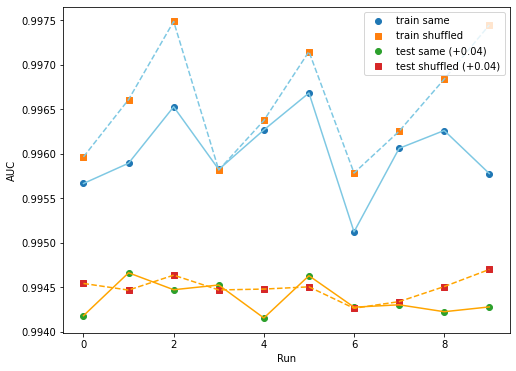

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(same_train_auc, color='#7EC8E3')
plt.plot(same_test_auc + 0.04, color='orange')
plt.plot(shuffled_train_auc, color='#7EC8E3', linestyle='dashed')
plt.plot(shuffled_test_auc + 0.04, color='orange', linestyle='dashed')

plt.scatter(range(NUM_RUNS), same_train_auc, label='train same')
plt.scatter(range(NUM_RUNS), shuffled_train_auc, marker='s', label='train shuffled')
plt.scatter(range(NUM_RUNS), same_test_auc + 0.04, label='test same (+0.04)')
plt.scatter(range(NUM_RUNS), shuffled_test_auc + 0.04, marker='s', label='test shuffled (+0.04)')

plt.legend()
plt.xlabel('Run')
plt.ylabel('AUC');

In [192]:
print("Generalization Gap (Train AUC - Test AUC):")
print(f"(Shuffled) {(shuffled_train_auc - shuffled_test_auc).mean(): .6f} ±{(shuffled_train_auc - shuffled_test_auc).std(): .6f}")
print(f"(Same)     {(same_train_auc - same_test_auc).mean(): .6f} ±{(same_train_auc - same_test_auc).std(): .6f}")

Generalization Gap (Train AUC - Test AUC):
(Shuffled)  0.042083 ± 0.000527
(Same)      0.041639 ± 0.000412


In [195]:
print(f"(Same Test - Shuffled Test): {(same_test_auc - shuffled_test_auc).mean(): .6f} ±{(same_test_auc - shuffled_test_auc).std(): .6f}")

(Same Test - Shuffled Test): -0.000120 ± 0.000208


Shuffled tends to overfit a bit more, but also tends to outpeform same folds. The rate at which shuffled overfits (in the sense of train-test AUC score gap) relative to same folds is one order of magnitude larger than the rate by which it outperforms same folds. Finally, if we look at CV scores at the fold level, there does not seem to be significant differences between the two schemes. 

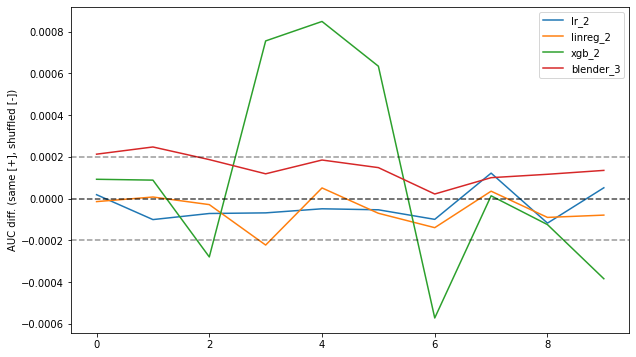

In [179]:
same_minus_shuffled_cv = same_cv_results - shuffled_cv_results
diffs = [pd.DataFrame(same_minus_shuffled_cv.iloc[0: NUM_FOLDS, 3:].mean()).T]
for i in range(1, NUM_RUNS):
    diffs.append(pd.DataFrame(same_minus_shuffled_cv.iloc[NUM_FOLDS*i: NUM_FOLDS*(i+1), 3:].mean()).T)
    
pd.concat(diffs).plot(use_index=False, figsize=(10, 6), 
                      ylabel='AUC diff. (same [+], shuffled [-])', xlabel='runs'
)
plt.axhline(+0.0002, linestyle='--', color='k', alpha=0.4)
plt.axhline(+0.0000, linestyle='--', color='k', alpha=0.7)
plt.axhline(-0.0002, linestyle='--', color='k', alpha=0.4);

**Figure.** Average over folds of CV score difference for each run of the experiment. Blender model shows a postive score for the same folds method.

### Conclusion

Empirical results above suggest that we should use the **same folds** across levels of stacking to minimize generalization gap &mdash; since the improvement in score is small compared to the risk of overfitting. The following theoretical example shows that, when using different folds, overfitting can happen due to the second stage model taking advantage of a certain relationship between ground truth and first stage predictions, without this structure generalizing well to the test set.

Consider a dataset $\{(x_1, t_1), (x_2, t_2) \ldots, (x_{10}, t_{10})\}$ with five folds such that the first fold is $F_1 = \{x_1, x_2\}$. Let $x_1 {\mapsto} y_1$ and $x_2 \mapsto y_2$ where the mapping is trained on $F_{\neg 1} = \{x_3, \ldots, x_{10}\}.$ Modelling on $F_{\neg 1}$ defines some rule or distribution that the points in $F_1$ are compared against. Suppose we reshuffle folds in the next level such that the first fold is $G_1 = \{y_1, y_{10}\}.$ Then, the model trained on $G_{\neg 1} = \{y_2, \ldots y_9\}$  overfits slightly since $y_2$ is modelled using the ground truths $(x_3, t_3), \ldots, (x_{9}, t_9).$ This imbalance does not apply to the other values $y_3, \ldots, y_9$ in $G_{\neg 1}.$ It follows that keeping the same cross-validation folds prevents any such asymmetry from occurring.

Theoretically (as mentioned in the [Kaggle Guide to Model Stacking](https://datasciblog.github.io/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/)), there is always some leakage if you train a second level model on the same training set, which you used to derive the first stage predictions. This is because you used the ground truth to get those first stage predictions, and now you take those predictions as input, and try to predict the same ground truth. However, this leakage doesn't seem to be significant in practice.